# Creating a TPF and LCF

In this tutorial, we will learn the basics of `tess_asteroids` by creating a TPF and LCF for a couple of asteriods. We will also demonstrate how to measure the asteroid's rotation period from the lightcurve.

### Was my target observed by TESS?

Let's start with main-belt asteroid 1980 VR1. Firstly, we need to know if TESS observed this target and, if so, in what observing sector/camera/CCD. We can use `tess_ephem` to find this out:

In [1]:
from tess_ephem import ephem

eph = ephem("1980 VR1")

# Print the unique combinations of sector/camera/CCD
eph[['sector', 'camera', 'ccd']].drop_duplicates().reset_index(drop=True)

sector  camera  ccd
0       1       1    2
1       1       1    1
2      68       1    2

Looks like our target was observed by TESS in sectors 1 and 68. Great, now we can create a TPF and LCF for that data!

### Creating a TPF and LCF

We can only create a TPF for one sector/camera/CCD at a time. Let's use sector 1, camera 1, CCD 1 as an example. 

Initialising `MovingTPF` with `from_name()` will query the JPL/Horizons database for the target's ephemeris during that sector. The `make_tpf()` function will then retrieve the relevant pixel data, correct the background flux and define the target aperture.

In [2]:
from tess_asteroids import MovingTPF

# Initialise MovingTPF for asteroid 1980 VR1 in TESS sector 1, camera 1, CCD 1
target = MovingTPF.from_name("1980 VR1", sector=1, camera=1, ccd=1)

# Make TPF
target.make_tpf()

Warning from TESSSpacecraft(): {message : ErfaWarning('ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"'), category : 'ErfaWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/erfa/core.py', lineno : 133, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Column(s) >= 2093 '), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 56, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Column(s) >= 2093 '), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 56, line : None}
100%|███████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:16<00:00, 59.28it/s]


We can visualise the TPF by using the `animate_tpf()` function:

In [3]:
# Animate TPF
target.animate_tpf()

Now we've made our TPF, we can extract the lightcurve using aperture photometry.

In [4]:
# Make LC
target.make_lc()

Let's plot the lightcurve:

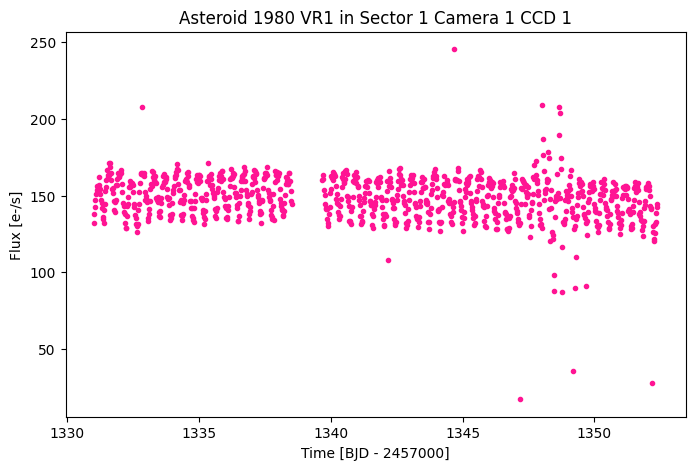

In [5]:
import matplotlib.pyplot as plt

lc = target.lc["aperture"]

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.scatter(lc["time"], lc["flux"], color="deeppink", marker=".")
ax.set_xlabel("Time [BJD - 2457000]")
ax.set_ylabel("Flux [e-/s]")
ax.set_title(f"Asteroid {target.target} in Sector {target.sector} Camera {target.camera} CCD {target.ccd}");

We can use the quality flags from SPOC and tess_asteroids to mask cadences of lesser quality. We mask the SPOC bits recommended in the TESS archive manual (excluding those that are not included in FFI data) and we also mask cadences where at least one pixel inside the aperture is either a non-science pixel or a saturated pixel.

In [6]:
import numpy as np

# Define array of bad binary digits from SPOC
bad_spoc_bits = [1,3,5,6,15]
spoc_value = 0
for bit in bad_spoc_bits:
    spoc_value += 2**(bit-1)
    
# Define array of bad binary digits from tess_asteroids (any cadence with non-science or saturated pixels in aperture)
bad_bits = [2,4]
ta_value = 0
for bit in bad_bits:
    ta_value += 2**(bit-1)

# Joint quality mask
quality_mask = np.logical_and(lc["quality"] & ta_value == 0, target.quality & spoc_value == 0)

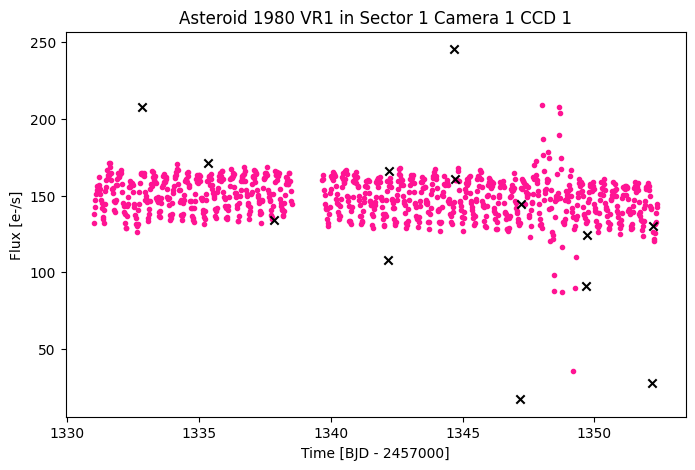

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.scatter(lc["time"][quality_mask], lc["flux"][quality_mask], color="deeppink", marker=".")
ax.scatter(lc["time"][~quality_mask], lc["flux"][~quality_mask], color="black", marker="x")
ax.set_xlabel("Time [BJD - 2457000]")
ax.set_ylabel("Flux [e-/s]")
ax.set_title(f"Asteroid {target.target} in Sector {target.sector} Camera {target.camera} CCD {target.ccd}");

### Rotation period analysis

In the JPL Small Body Database, 1980 VR1 is reported to have a rotation period of 10.215 hrs. Let's see if our lightcurve agrees with that.

In [8]:
# Remove nans from LC (periodograms don't like nans!)
no_nan = np.logical_and(~np.isnan(np.array(lc["flux"])), ~np.isnan(np.array(lc["flux_err"])))
time, flux, flux_err = lc["time"][no_nan], lc["flux"][no_nan], lc["flux_err"][no_nan]
print("Before masking = {0}".format(len(lc["time"])))
print("After nan masking = {0}".format(len(time)))

# Remove flux=0.0 from LC (possible artefact of BG subtraction)
no_zero = flux != 0.0
time, flux, flux_err = time[no_zero], flux[no_zero], flux_err[no_zero]
print("After zero masking = {0}".format(len(time)))

# Remove poor quality data from LC, using the same definition as above
good_quality = np.logical_and(lc["quality"][no_nan][no_zero] & ta_value == 0, target.quality[no_nan][no_zero] & spoc_value == 0)
time, flux, flux_err = time[good_quality], flux[good_quality], flux_err[good_quality]
print("After bad data masking = {0}".format(len(time)))

Before masking = 972
After nan masking = 972
After zero masking = 972
After bad data masking = 959


In [9]:
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks

# Min/max period, in days, and frequency
cadence = 30/60/24   # sector 1 had 30min observing cadence
Pmin, Pmax = cadence*2, (np.nanmax(time)-np.nanmin(time))
fmin, fmax = 1/Pmax, 1/Pmin

# Define period and frequency grid
frequency_grid = np.linspace(fmin, fmax, 10000)
period_grid = 1.0/frequency_grid

# Run periodogram
ls = LombScargle(time, flux, flux_err)
power = ls.power(frequency_grid)

# False alarm levels
probabilities = [0.1,0.05,0.01]
false_alarm_levels = ls.false_alarm_level(probabilities)

# Find peaks in the periodogram above 1% FAP.
level = false_alarm_levels[2]
peaks, peak_properties = find_peaks(power, height=level)
peak_periods = period_grid[peaks]
sorted_ind = np.argsort(peak_properties["peak_heights"])[::-1]
best_period = peak_periods[sorted_ind[0]]*24

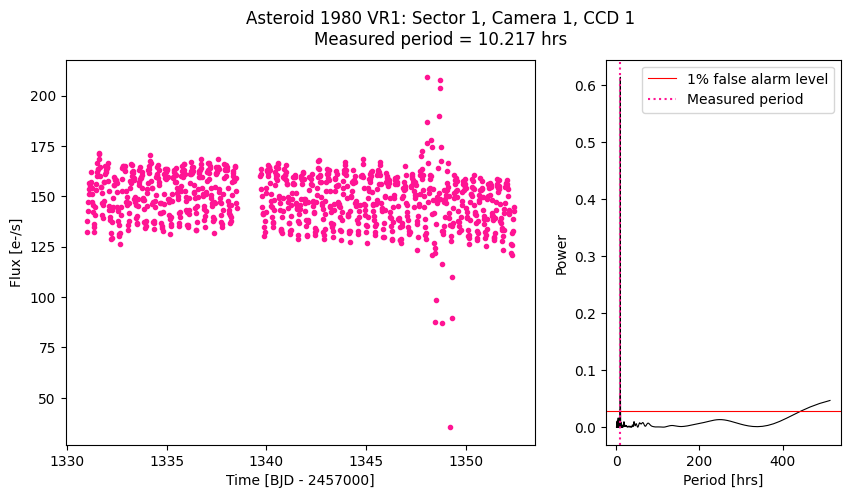

In [10]:
# Plot the LC and periodogram
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5), width_ratios=[2,1])

ax1.scatter(time, flux, color='deeppink', marker='.')
ax1.set_xlabel("Time [BJD - 2457000]")
ax1.set_ylabel("Flux [e-/s]")

ax2.plot(period_grid*24, power, 'k', lw=0.8, zorder=0)
ax2.axhline(y=level, color='r', lw=0.8, label = "1% false alarm level")
ax2.axvline(x=best_period, ls=':', color='deeppink', zorder=2, label = "Measured period")
ax2.set_xlabel("Period [hrs]")
ax2.set_ylabel("Power")
ax2.legend(loc="upper right")

fig.suptitle("Asteroid {0}: Sector {1}, Camera {2}, CCD {3}\nMeasured period = {4:.03f} hrs".format(target.target, target.sector,target.camera,target.ccd,best_period));

Hooray, our results show good agreement with the expected rotation period!

### Another example

Let's now have a quick look at near-Earth asteroid 2013 OS3:

In [11]:
eph = ephem("2013 OS3")
eph[['sector', 'camera', 'ccd']].drop_duplicates().reset_index(drop=True)

sector  camera  ccd
0      20       2    1
1      20       2    2
2      20       2    3
3      20       1    2
4      20       1    3
5      93       2    3
6      93       1    2

In [12]:
# Initialise MovingTPF for asteroid 2013 OS3 in TESS sector 20, camera 2, CCD 3
target = MovingTPF.from_name("2013 OS3", sector=20, camera=2, ccd=3)

# Make TPF
target.make_tpf()

# Animate TPF
target.animate_tpf()

Some of the requested pixels are outside of the FFI science array (1<=row<=2048, 45<=col<=2092), but they will be set to NaN in your TPF.
Warning from TESSSpacecraft(): {message : ErfaWarning('ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"'), category : 'ErfaWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/erfa/core.py', lineno : 133, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Column(s) >= 2093 '), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 56, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Row(s) > 2048)'), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 62, line : None}
The PRF model contained nans in the first frame (cadence number 591). The model was replaced with that from the

The first cadence is filled with NaN values because these are non-science pixels.

Notice that this asteroid has a more elongated shape. That's because 2013 OS3 moves across the sky much more quickly than 1980 VR1, and during the long exposures the flux gets smeared along the trail. In a few of the frames, the asteroid reaches the edge of the TPF, so we are probably losing some of the target's flux. That's no problem, we can create a larger TPF to ensure we capture all of the flux!

In [13]:
# Make TPF - increased shape
target.make_tpf(shape=(15,15))

# Animate TPF
target.animate_tpf()

Some of the requested pixels are outside of the FFI science array (1<=row<=2048, 45<=col<=2092), but they will be set to NaN in your TPF.
Warning from TESSSpacecraft(): {message : ErfaWarning('ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"'), category : 'ErfaWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/erfa/core.py', lineno : 133, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Column(s) >= 2093 '), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 56, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Row(s) > 2048)'), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 62, line : None}
The PRF model contained nans in the first frame (cadence number 591). The model was replaced with that from the

That looks better, the target is more comfortably within the bounds of the TPF now.

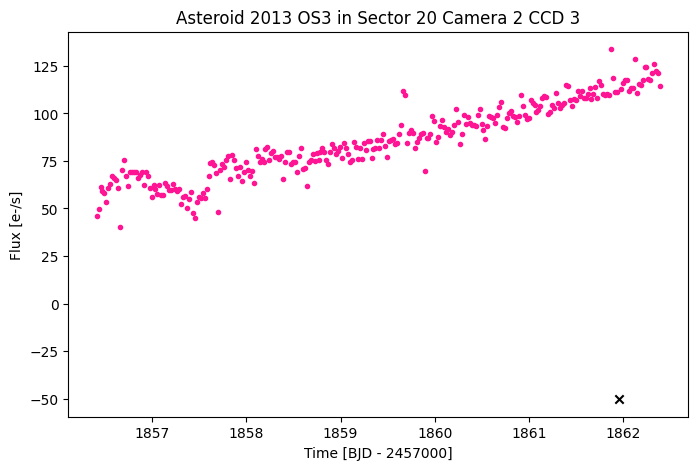

In [14]:
# Make LC
target.make_lc()

lc = target.lc["aperture"]

# Joint quality mask
quality_mask = np.logical_and(lc["quality"] & ta_value == 0, target.quality & spoc_value == 0)

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.scatter(lc["time"][quality_mask], lc["flux"][quality_mask], color="deeppink", marker=".")
ax.scatter(lc["time"][~quality_mask], lc["flux"][~quality_mask], color="black", marker="x")
ax.set_xlabel("Time [BJD - 2457000]")
ax.set_ylabel("Flux [e-/s]")
ax.set_title(f"Asteroid {target.target} in Sector {target.sector} Camera {target.camera} CCD {target.ccd}");

2013 OS3 was only observed on camera 2, CCD 3 for about 5 days, so the lightcurve is much shorter than the length of a full TESS observing sector (~27 days).